In [1]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes import black_scholes
from datetime import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from functools import reduce

%matplotlib inline

In [2]:
# Get risk free rate
rf = yf.Ticker('^TNX').info['regularMarketPrice'] / 100.

In [3]:
def option(underlying_price, strike_price, expires_on, contract_price, n_contracts, contract_type, contract_party):
    iv = implied_volatility(contract_price,
                            underlying_price,
                            strike_price,
                            (expires_on - datetime.now()).days / 365.,
                            rf,
                            contract_type)
    return {
        'underlying_price': underlying_price,
        'strike_price': strike_price,
        'expires_on': expires_on,
        'contract_price': contract_price,
        'n_contracts': n_contracts,
        'contract_type': contract_type,
        'contract_party': contract_party,
        'iv': iv
    }

In [4]:
def long_call(underlying_price, strike_price, expires_on, contract_price, n_contracts):
    return option(underlying_price, strike_price, expires_on, contract_price, n_contracts, 'c', 'buy')

def short_call(underlying_price, strike_price, expires_on, contract_price, n_contracts):
    return option(underlying_price, strike_price, expires_on, contract_price, n_contracts, 'c', 'sell')

def long_put(underlying_price, strike_price, expires_on, contract_price, n_contracts):
    return option(underlying_price, strike_price, expires_on, contract_price, n_contracts, 'p', 'buy')

def short_put(underlying_price, strike_price, expires_on, contract_price, n_contracts):
    return option(underlying_price, strike_price, expires_on, contract_price, n_contracts, 'p', 'sell')

In [12]:
def entry_cost(option):
    # each contract is one hundred shares, net cost is negative i.e. credit for selling
    price = option['n_contracts'] * option['contract_price']
    if option['contract_party'] == 'sell':
        price *= -1
    return price * 100

def compute_strategy(date_start, date_end, day_ticks, price_lower, price_upper, strategy):
    # Strategy is a list of options
    
    # Get list of days to check
    date_range = pd.date_range(date_start,
                  date_end,
                  day_ticks).normalize().tolist()
    idx = list(range(price_lower, price_upper + 1, 1))
    idx.reverse()
    
    net_cost = sum([entry_cost(option) for option in strategy])
    
    def compute_single_profit(option, d, theo_price):
        option_value = black_scholes(option['contract_type'], 
                       theo_price, 
                       option['strike_price'], 
                       ((option['expires_on'] - d).days / 365.),
                       rf,
                       option['iv']) * option['n_contracts'] * 100
        if option['contract_party'] == 'buy':
            return option_value
        else:
            return (option['contract_price'] * option['n_contracts']) - option_value
        
    def compute_values(option):
        return pd.DataFrame(
            [
                [compute_single_profit(option, d, theo_price) for d in date_range]
                for theo_price in idx
            ], index=idx, columns = date_range)
    
    df_strategy_values = [compute_values(option) for option in strategy]
    df_combined_strategy_values = reduce(lambda x, y: x.add(y), df_strategy_values)
    return df_combined_strategy_values, net_cost


In [13]:
gains, net_cost = compute_strategy(
    date_start = datetime(2020, 5, 20),
    date_end = datetime(2020, 6, 22),
    day_ticks = 30,
    price_lower = 273,
    price_upper = 322,
    # Strangle
    strategy = [
        long_call(underlying_price=296.2359,
                  strike_price=280,
                  expires_on=datetime(2020,6,22),
                  contract_price=20.38,
                  n_contracts=1),
        long_put(underlying_price=296.2359,
                  strike_price=330,
                  expires_on=datetime(2020,6,22),
                  contract_price=35.11,
                  n_contracts=1)]
)

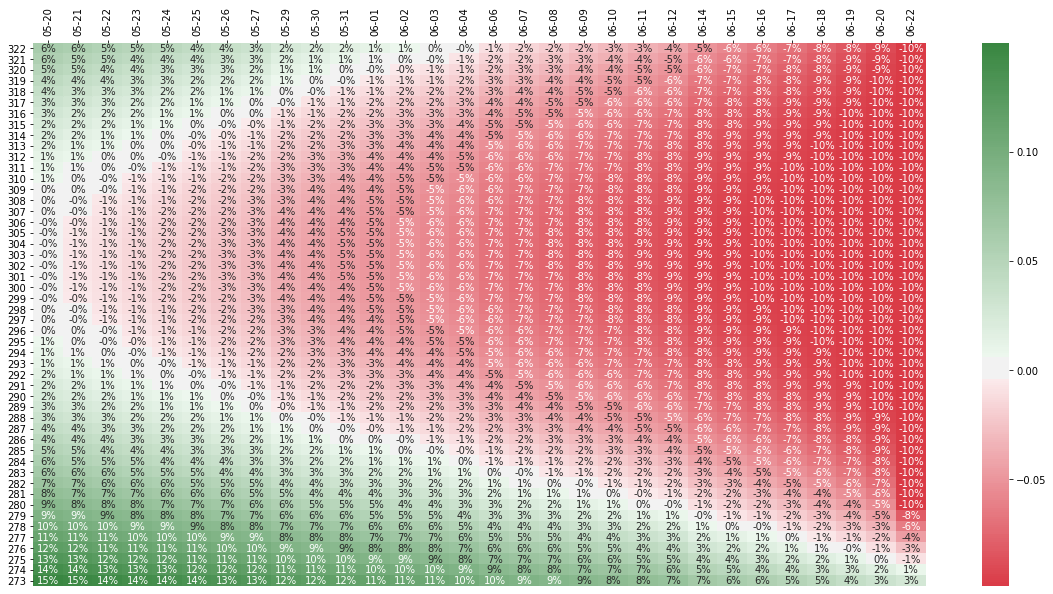

In [17]:
return_pcts = (gains / net_cost) - 1
plt.figure(figsize=(20,10))

divnorm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=return_pcts.max().max())
ax = sb.heatmap(
    return_pcts,
    annot=True,
    fmt = '.0%',
    norm = divnorm,
    cmap = sb.diverging_palette(h_neg=10, h_pos=130, as_cmap=True))
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(result.columns.strftime('%m-%d'), rotation=90)
ax.set_yticklabels(result.index, rotation=0)
plt.show()

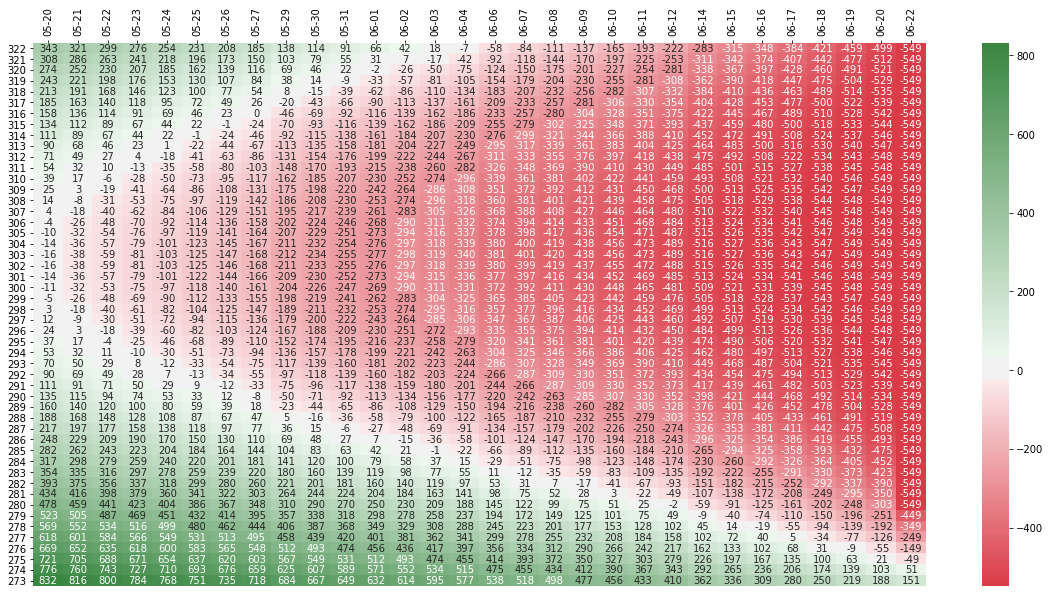

In [7]:
plt.figure(figsize=(20,10))

divnorm = TwoSlopeNorm(vcenter=0, vmin=result.min().min(), vmax=result.max().max())
ax = sb.heatmap(
    result.round().astype(int),
    annot=True,
    fmt = 'd',
    norm = divnorm,
    cmap = sb.diverging_palette(h_neg=10, h_pos=130, as_cmap=True))
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(result.columns.strftime('%m-%d'), rotation=90)
ax.set_yticklabels(result.index, rotation=0)
plt.show()